### Constantes

In [27]:
IMAGE_SIZE = 640

labels = {'standing': 0, 'takedown': 1, 'open_guard': 2, 'half_guard': 3, 'closed_guard': 4, '5050_guard': 5, 'side_control': 6, 'mount': 7, 'back': 8, 'turtle': 9}
body_parts = ["nose", "left eye", "right eye", "left ear", "right ear", "left shoulder", "right shoulder", "left elbow", "right elbow", "left wrist", "right wrist", "left hip", "right hip", "left knee", "right knee", "left ankle", "right ankle"]
num_labels = len(labels)
num_keypoints = 17
num_players = 2

### Importando modelo coco


In [28]:
# STEP 1: Import the necessary modules.
from ultralytics import YOLO

# Load a model
pose_model = YOLO('../../assets/coco_model/yolov8x-pose-p6.pt') 

### Testando modelo

In [29]:
import cv2 as cv
import matplotlib.pyplot as plt

def draw_image_with_keypoints(image_path, keypoints):
    image = cv.imread(image_path)

    image = cv.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

    for keypoint_set in keypoints:
        for i in range(num_keypoints):
            x = int(keypoint_set[i][0])
            y = int(keypoint_set[i][1])
            cv.circle(image, (x, y), 5, (255, 0, 0), -1)
        
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()

### Carregando modelo pose BJJ

In [30]:
import tensorflow as tf

model = tf.keras.models.load_model("jiu_model.h5")

### Funções úteis

In [31]:
import matplotlib.pyplot as plt # type: ignore
import numpy as np

def get_keypoints(image_path):
    predictions = pose_model(image_path)[0]
    
    if len(predictions) == 0:
        return None
    
    keypoints = predictions[0].keypoints
    keypoints_tensor = keypoints.data
    keypoints = keypoints_tensor.numpy()
    
    if len(predictions) > 1:
        keypoints2 = predictions[1].keypoints
        keypoints_tensor2 = keypoints2.data
        keypoints2 = keypoints_tensor2.numpy()
    else:
        keypoints2 = np.array([[[0, 0, 0]] * num_keypoints])
    
    keypoints = np.concatenate((keypoints, keypoints2), axis=0)
    
    return keypoints

def pose_prediction(keypoints):
    keypoints = np.array(keypoints)
    
    keypoints = keypoints.reshape(1, num_keypoints * 3 * 2)
    
    max_x = np.max(keypoints)
    
    keypoints = keypoints / max_x
    
    print("Keypoints: ", keypoints.flatten() * max_x)
    
    prediction = model.predict(keypoints)
    
    max_index = np.argmax(prediction)
    
    return max_index   

### Classificação em imagem única


image 1/1 c:\Users\guilh\Documents\bjj_ia\reference\v3\..\..\tmp\temp.jpg: 1280x1280 2 persons, 3726.5ms
Speed: 11.0ms preprocess, 3726.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)


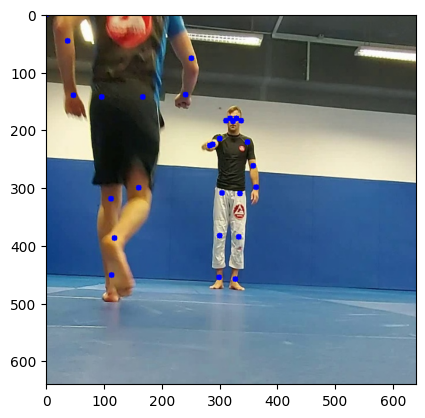

Keypoints:  [          0           0  8.5847e-05           0           0  1.3541e-05           0           0  1.9576e-05           0           0   0.0012528           0           0   0.0022468           0           0     0.10052           0           0     0.10142      37.565       46.49     0.86923      251.41      76.435
      0.8726      47.998      140.01     0.95098      241.44      139.41     0.94756      96.917      143.71      0.9977      167.84      143.68     0.99729      112.08      319.38     0.99821      160.08      300.48     0.99765      113.74      451.58     0.98583      118.29      387.61     0.98485       323.3
      185.31     0.99903      329.05      180.11     0.99694      318.56      180.13     0.99386      337.24      184.89     0.91489      311.56       184.4     0.81116      348.93      221.14     0.99952      300.41      215.23     0.99884      358.25       262.6     0.99485      288.53      225.96     0.98023
      363.11      299.53     0.99081      283.64 

ValueError: in user code:

    File "c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 68), found shape=(None, 102)


In [32]:
import os

image_path = '../../assets/images/standing.jpg'

temp_path = '../../tmp'

# resize the image
image = cv.imread(image_path)

image = cv.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

cv.imwrite(temp_path + '/temp.jpg', image)

keypoints = get_keypoints(temp_path + '/temp.jpg')

draw_image_with_keypoints(temp_path + '/temp.jpg', keypoints)

label_index = pose_prediction(keypoints)

print("Predicted Label: ", list(labels.keys())[label_index])

os.remove(temp_path + '/temp.jpg')

### Classificação em vídeo em tempo real

In [33]:
import cv2 # type: ignore

cap = cv2.VideoCapture("../../assets/videos/video.mp4")

while cap.isOpened():
    
    ret, frame = cap.read()
    
    if not ret:
        break
    
    frame = cv2.resize(frame, (IMAGE_SIZE, IMAGE_SIZE))
    
    keypoints = get_keypoints(frame)
    
    if keypoints is None:
        continue
    
    #label_index = pose_prediction(keypoints)
    
    #label = list(labels.keys())[label_index]
    
    #cv2.putText(frame, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    for keypoint_set in keypoints:
        for i in range(num_keypoints):
            x = int(keypoint_set[i][0].item())
            y = int(keypoint_set[i][1].item())
            cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)
    
    cv2.imshow("Frame", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break


0: 1280x1280 2 persons, 3766.3ms
Speed: 18.0ms preprocess, 3766.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)

0: 1280x1280 2 persons, 3401.9ms
Speed: 10.6ms preprocess, 3401.9ms inference, 2.0ms postprocess per image at shape (1, 3, 1280, 1280)

0: 1280x1280 2 persons, 3376.1ms
Speed: 11.9ms preprocess, 3376.1ms inference, 2.0ms postprocess per image at shape (1, 3, 1280, 1280)

0: 1280x1280 2 persons, 3273.1ms
Speed: 11.0ms preprocess, 3273.1ms inference, 0.0ms postprocess per image at shape (1, 3, 1280, 1280)

0: 1280x1280 2 persons, 3240.2ms
Speed: 9.0ms preprocess, 3240.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)

0: 1280x1280 2 persons, 3266.3ms
Speed: 11.0ms preprocess, 3266.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)

0: 1280x1280 2 persons, 3378.0ms
Speed: 11.0ms preprocess, 3378.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)



KeyboardInterrupt: 